# Compiling Circuits for EeroQ via Qiskit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/eeroq/eeroq_qss.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/eeroq/eeroq_qss.ipynb)

Below is a brief tutorial on Superstaq compilation for EeroQ Quantum Hardware whose quantum computer uses electrons bound to superfluid helium. For more information on EeroQ, visit their website [here](https://eeroq.com/).

## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq`:

In [1]:
# Required imports
try:
    import qiskit
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit
    import qiskit_superstaq as qss

# Optional imports
import os  # Used if setting a token as an environment variable

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API))

In [2]:
# Instantiate a qiskit superstaq provider
provider = qss.SuperstaqProvider()

## EeroQ Gates

One of the native gates that EeroQ devices operate is the Dipole-Dipole (DD) gate, which couples two electrons. This gate can be applied to electrons within a qubit to perform rotation gates, or across qubits to perform entangling gates. The DD gate is available as a custom gate in `qiskit-superstaq`.

In [3]:
dd_gate = qss.DDGate(1)

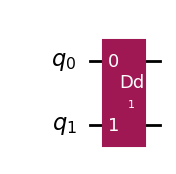

In [ ]:
# Define a simple circuit with a DD gate
qc = qiskit.QuantumCircuit(2)
qc.append(dd_gate, [0, 1])
qc.draw("mpl")

Below is the EeroQ protocol for a CZ Gate.

![title](images/DD_gate.png)

## Single Circuit Compilation

With that gateset, we can compile to the EeroQ Wonderlake device by instantiating an EeroQ backend. We can then call the `compile` method on that backend.

We can compile to the EeroQ Wonderlake device by instantiating an EeroQ backend. We can then call the `backend.compile` method.

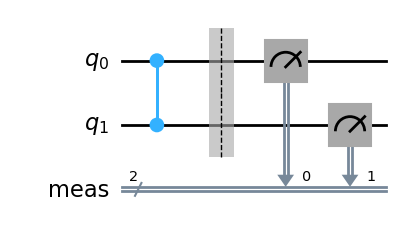

In [5]:
# Create a two-qubit qiskit circuit
qc = qiskit.QuantumCircuit(2)
qc.cz(0, 1)
qc.measure_all()

# Draw circuit for visualization
qc.draw("mpl")

In [6]:
# Create the backend to compile for
backend = provider.get_backend("eeroq_wonderlake_qpu")

In [7]:
# Compile circuit and retrieve by calling `.circuit`
compiled_circuit = backend.compile(qc).circuit

Below we define some helper functions to remove any inactive qubits in the compiled circuit:

In [8]:
def count_gates(qc: qiskit.QuantumCircuit):
    gate_count = {qubit: 0 for qubit in qc.qubits}
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit] += 1
    return gate_count


def remove_idle_wires(qc: qiskit.QuantumCircuit):
    qc_out = qc.copy()
    gate_count = count_gates(qc_out)
    for qubit, count in gate_count.items():
        if count == 0:
            qc_out.qubits.remove(qubit)
    return qc_out

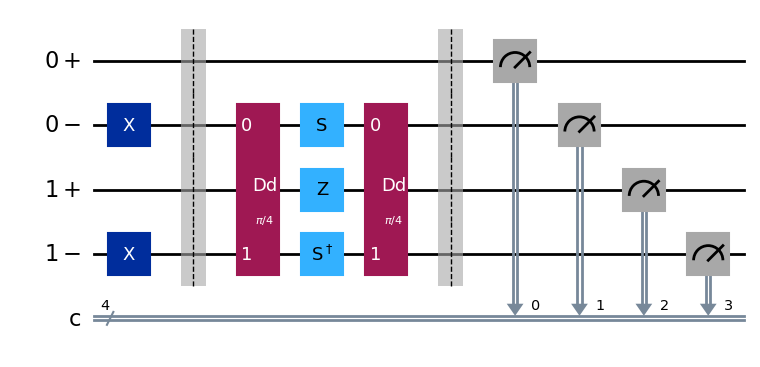

In [9]:
# Visualize the compiled circuit
remove_idle_wires(compiled_circuit).draw("mpl")

## Multiple Circuit Compilation

We can repeat the above experiment with larger circuits to see how they compile. Instead of compiling a single circuit at a time, we can also compile a list of circuits in one-go. To illustrate this, let us create two circuits: a Bell circuit, and another randomly generated qiskit circuit: 

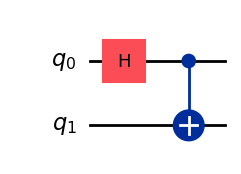

In [10]:
bell_qc = qiskit.QuantumCircuit(2)
bell_qc.h(0)
bell_qc.cx(0, 1)
bell_qc.draw("mpl")

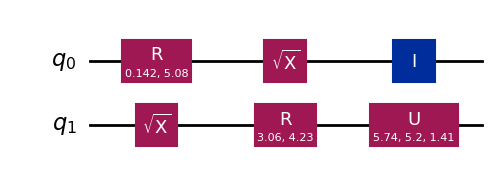

In [11]:
rand_qc = qiskit.circuit.random.random_circuit(2, 3, measure=False)
rand_qc.draw("mpl")

In [12]:
# Pass in a list of circuits to `compile`
compiled_outputs = backend.compile([bell_qc, rand_qc])

# To get the list of compiled circuits from the compiled outputs list, call `circuits` instead of just `circuit` which was called for the single circuit input
compiled_circuits = compiled_outputs.circuits

Here's the compiled Bell circuit,

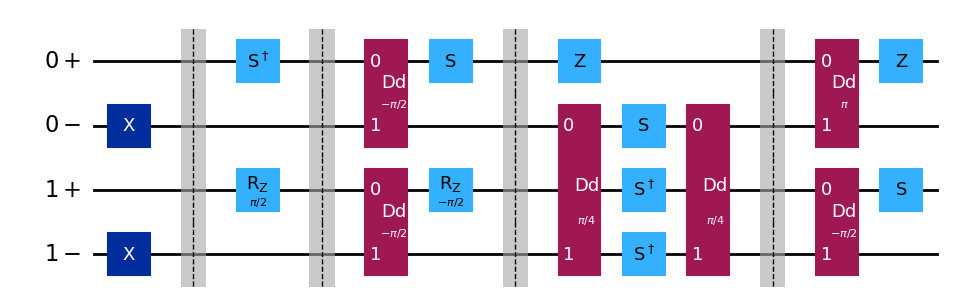

In [13]:
remove_idle_wires(compiled_circuits[0]).draw("mpl")

And the compiled random circuit, fully expressed in the native gateset of EeroQ:

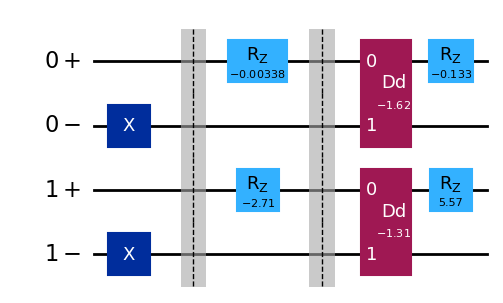

In [14]:
remove_idle_wires(compiled_circuits[1]).draw("mpl", fold=-1)

## Using the Superstaq Simulator

Lastly, we will go over how to simulate a circuit to the EeroQ Wonderlake QPU. This feature is available to free trial users, and can be done by passing the `"dry-run"` method parameter when calling `backend.run()` to instruct Superstaq to ideally sample the circuit. Let us generate a random circuit again to demonstrate: 

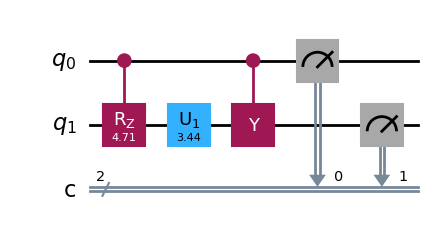

In [15]:
# Example random circuit including measurements
qc = qiskit.circuit.random.random_circuit(2, 3, measure=True)
qc.draw("mpl")

In [ ]:
# Specify "dry-run" as the method to run an ideal Superstaq execution
job = backend.run(qc, shots=1000, method="dry-run")

# Get the counts from the measurement
print(job.result(0).get_counts())

{'00': 1000}


We can additionally perform a noisy simulation of the circuit by setting the `method` argument to `"noise-sim"` and specifying an error rate.

In [17]:
noisy_job = backend.run(qc, shots=1000, method="noise-sim", error_rate=0.01)

In [18]:
print(noisy_job.result(0).get_counts())

{'00': 892, '12': 16, '10': 21, '20': 31, '22': 6, '02': 9}


With the effect of noise, we no longer just measure $\ket{00}$ like in the dry-run simulation. Note that a measurement value of 2 refers to an out-of-codespace error.